# Convolutional Neural Network for CIFAR-10 Image Classification

## Project Overview

This notebook demonstrates the implementation of a **Convolutional Neural Network (CNN)** for image classification on the **CIFAR-10 dataset** using PyTorch. The CIFAR-10 dataset consists of 60,000 32x32 color images across 10 different classes, with 50,000 training images and 10,000 test images.

### Objectives
- Build a CNN architecture from scratch using PyTorch
- Train the model on CIFAR-10 dataset
- Evaluate model performance on test data
- Visualize training progress and predictions

### Dataset Classes
The CIFAR-10 dataset includes the following 10 classes:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

### Technologies Used
- **PyTorch**: Deep learning framework
- **TorchVision**: Computer vision datasets and transforms
- **NumPy**: Numerical computing
- **Matplotlib**: Data visualization

---

## 1. Import Required Libraries

We begin by importing all necessary libraries for data loading, model building, training, and visualization.

In [1]:
# DL framework
import torch
import torchvision

# data visualization
import matplotlib.pyplot as plt

# numerical operations
import numpy as np

# setting the default figure size for all plots
plt.rcParams['figure.figsize'] = 14, 6

## 2. Data Loading and Preprocessing

### Data Transformations

We apply two key transformations to our data:
1. **ToTensor()**: Converts PIL images or NumPy arrays to PyTorch tensors and scales pixel values from [0, 255] to [0, 1]
2. **Normalize()**: Normalizes the tensor with mean=0.5 and std=0.5 for each channel, scaling values to [-1, 1]

**Why normalize?** Normalization helps:
- Speed up convergence during training
- Prevent gradient explosion/vanishing
- Improve model generalization

In [2]:
# transformation pipeline
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

# loading CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(
    root = "./CIFAR10/train",
    train=True,
    transform=normalize_transform,
    download=True
)

# load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root = "./CIFAR10/train",
    train=False,
    transform=normalize_transform,
    download=True
)

print(f"Traing samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Traing samples: 50000
Test samples: 10000
Number of classes: 10


## 3. Create Data Loaders

DataLoaders handle batching, shuffling, and parallel data loading, making the training process more efficient.

**Batch Size**: We use a batch size of 128, which is a good balance between:
- Memory efficiency
- Training speed
- Gradient estimation quality

In [3]:
# batch size
batch_size = 128

# training data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# test data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 391
Number of test batches: 79


## 4. Visualize Sample Images

Let's visualize a grid of sample images from our training dataset to understand what our model will be learning from.

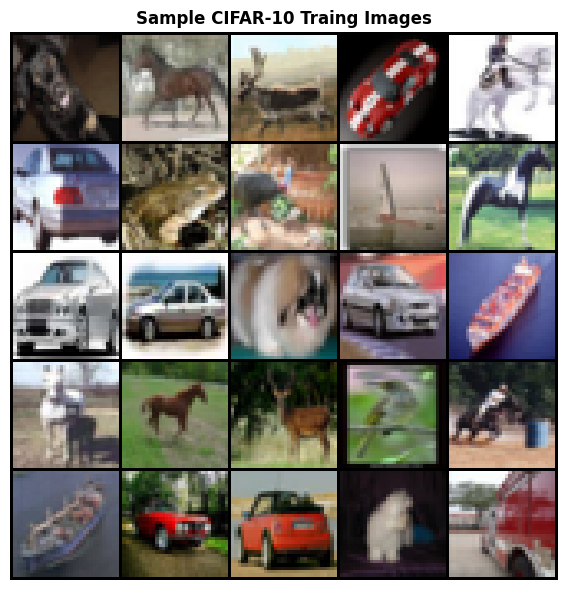

In [4]:
# get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# grid of images (25 images)
image_grid = torchvision.utils.make_grid(
    images[25:50],
    normalize=True,
    padding=1,
    nrow=5
)

# converting from (C, H, W) to (H, W, C) for matplotlib
img_grid_np = np.transpose(image_grid.numpy(), (1, 2, 0))

# display the grid
plt.imshow(img_grid_np)
plt.title("Sample CIFAR-10 Traing Images", fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Analyze Class Distribution

It's important to check if our dataset is balanced across all classes. An imbalanced dataset can lead to biased predictions.

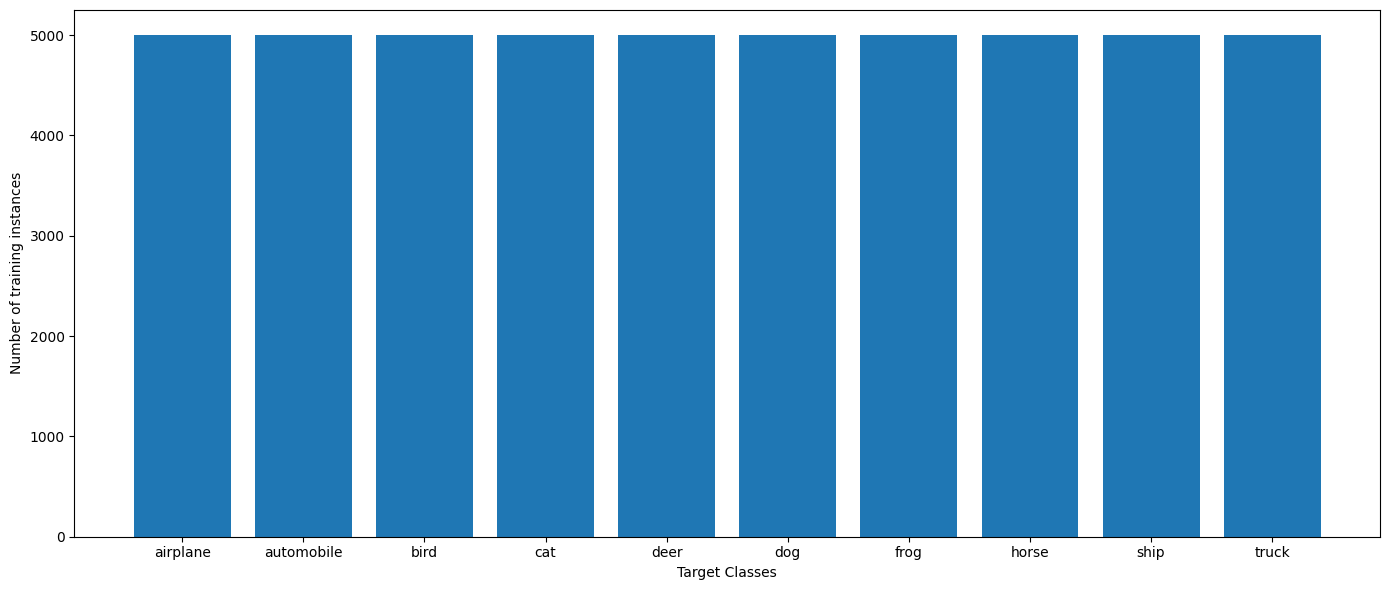

In [5]:
# collect all labels from the training dataset
classes = []
for batch_idx, data in enumerate(train_loader):
    images, labels = data
    classes.extend(labels.tolist())

# count occurance of each class
unique, counts = np.unique(classes, return_counts=True)

# get class names
names = list(test_dataset.class_to_idx.keys())

# plotting bar chart
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")
plt.tight_layout()
plt.show()

## 6. Define CNN Architecture

### Model Architecture

Our CNN consists of three main components:

#### **Convolutional Blocks** (Feature Extraction)
1. **Block 1**: Conv2D(3→32) → ReLU → MaxPool
   - Input: 3 channels (RGB), Output: 32 feature maps
   - Reduces spatial dimensions from 32×32 to 16×16

2. **Block 2**: Conv2D(32→64) → ReLU → MaxPool
   - Input: 32 channels, Output: 64 feature maps
   - Reduces spatial dimensions from 16×16 to 8×8

3. **Block 3**: Conv2D(64→64) → ReLU → MaxPool
   - Maintains 64 feature maps
   - Reduces spatial dimensions from 8×8 to 4×4
     
> **NOTE: in_channel = no. of channels in the input feature map**

> **out_channel = no. of filter/kernel**

> **kernel_size= 3 = 3x3**

#### **Fully Connected Layers** (Classification)
- **Flatten**: Converts 4×4×64 = 1024 features to 1D vector
- **FC1**: 1024 → 512 neurons with ReLU activation
- **FC2**: 512 → 10 output classes (no activation, handled by loss function)

### Key Design Choices
- **Padding=1**: Preserves spatial dimensions through convolution
- **Kernel size=3**: Standard choice for local feature detection
- **MaxPooling**: Reduces spatial size while retaining important features
- **ReLU activation**: Introduces non-linearity and helps with gradient flow



In [6]:
class CNN(torch.nn.Module):
    """
    Convolutional Neural Network for CIFAR-10 Classification.

    ArchitectureL
    - 3 Convolutional blocks (Conv → ReLU → MaxPool)
    - 2 Fully connected layers
    - Output: 10 classes
    """
    def __init__(self):
        super().__init__()
        
        self.model = torch.nn.Sequential(
            # Convolutional Block 1
            # input: 32x32x3 → Output: 32x16x16 (C, H, W)
            torch.nn.Conv2d(in_channels=3,           # RGB input
                            out_channels=32,         # 32 features map
                            kernel_size=3,           # 3x3 convolution
                            padding=1
                           ),
            torch.nn.ReLU(),                         # non-linear activation
            torch.nn.MaxPool2d(kernel_size=2),       # dowesample by 2

            # Convolutional Block 2
            # input: 32x16x16 → output: 64x8x8 
            torch.nn.Conv2d(in_channels=32,          # from previous layer
                            out_channels=64,         # 64 feature maps
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # Convolutional Block 3
            # input: 64x8x8 → output: 64x4x4
            torch.nn.Conv2d(in_channels=64,           
                            out_channels=64,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # fully connected layers
            torch.nn.Flatten(),                     # flatten to 1D: 64x4x4 = 1024
            torch.nn.Linear(64 * 4 * 4, 512),       # hidden layer with 512 neurons
            torch.nn.ReLU(),
            torch.nn.Linear(512,10)                 # output layer: 10 classes
        )

    def forward(self, x):
        """
        Foward pass through the network

        Args:
            x (torch.Tensor): Input tensor of shape (batch)size, 3, 32, 32)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, 10)
        """
        return self.model(x)
            

# creating a sample model to display architecture
sample_model = CNN()
print("CNN Architecture Summary")
print(sample_model)

# counting parameters
total_parameters = sum(p.numel() for p in sample_model.parameters())
trainable_parameters = sum(p.numel() for p in sample_model.parameters() if p.requires_grad)
print(f"\n\nTotal Parameters: {total_parameters:,}\n")
print(f"Trainable Parameters: {trainable_parameters:,}")

CNN Architecture Summary
CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)


Total Parameters: 586,250

Trainable Parameters: 586,250


## 7. Device Configuration

We check for hardware acceleration availability and configure the device accordingly:
- **MPS**: Apple Silicon GPU (M1/M2/M3 chips)
- **CUDA**: NVIDIA GPU
- **CPU**: Fallback option

In [7]:
# i'm directly applyiny the 'mps'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

## 8. Training Configuration

### Hyperparameters

- **Number of Epochs**: 50
  - One epoch = one complete pass through the training dataset
  
- **Learning Rate**: 0.001
  - Controls the step size during optimization
  - Too high → unstable training; Too low -> slow convergence
  
- **Weight Decay**: 0.01 (L2 Regularization)
  - Prevents overfitting by penalizing large weights
  - Helps the model generalize better to unseen data

### Loss Function & Optimizer

- **Loss**: CrossEntropyLoss
  - Combines softmax activation and negative log-likelihood
  - Suitable for multi-class classification
  
- **Optimizer**: Adam
  - Adaptive learning rate method
  - Combines benefits of RMSprop and momentum
  - Generally converges faster than SGD

In [8]:
# initializing the model and moving to device
model = CNN().to(device)

# training hyperparameters
num_epochs = 50
learning_rate = 0.001
weight_decay = 0.01

# loss function for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

# Adam optimizer with L2 regularization
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

## 9. Model Training

### Training Process

For each epoch, we:
1. **Forward Pass**: Feed images through the network to get predictions
2. **Calculate Loss**: Measure how far predictions are from true labels
3. **Backward Pass**: Compute gradients using backpropagation
4. **Update Weights**: Adjust model parameters using the optimizer

The training loop tracks the average loss per epoch to monitor convergence.

In [9]:
# list to store training loss for each epoch
train_loss_list= []

for epoch in range(num_epochs):
    # model to training mode
    model.train()

    train_loss = 0

    # iterating through training batches
    for images, labels in train_loader:
        # moving data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass: compute prediction
        outputs = model(images)

        # computing loss
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate loss
        train_loss += loss.item()

    # calculating the average loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    # printing the progress every 5 epochs
    if (epoch +1)% 5 == 0. or epoch ==0:
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | Training_loss: {avg_train_loss:.4f}")

# final training loss
print(f"Final Training loss= {train_loss_list[-1]:.4f}")
    

Epoch [ 1/50] | Training_loss: 1.6171
Epoch [ 5/50] | Training_loss: 1.0699
Epoch [10/50] | Training_loss: 0.9303
Epoch [15/50] | Training_loss: 0.8720
Epoch [20/50] | Training_loss: 0.8424
Epoch [25/50] | Training_loss: 0.8241
Epoch [30/50] | Training_loss: 0.8092
Epoch [35/50] | Training_loss: 0.7973
Epoch [40/50] | Training_loss: 0.7890
Epoch [45/50] | Training_loss: 0.7882
Epoch [50/50] | Training_loss: 0.7841
Final Training loss= 0.7841


## 10. Visualize Training Progress

Plotting the training loss helps us understand:
- Whether the model is learning (loss should decrease)
- If training has converged (loss plateaus)
- Potential issues like overfitting or divergence

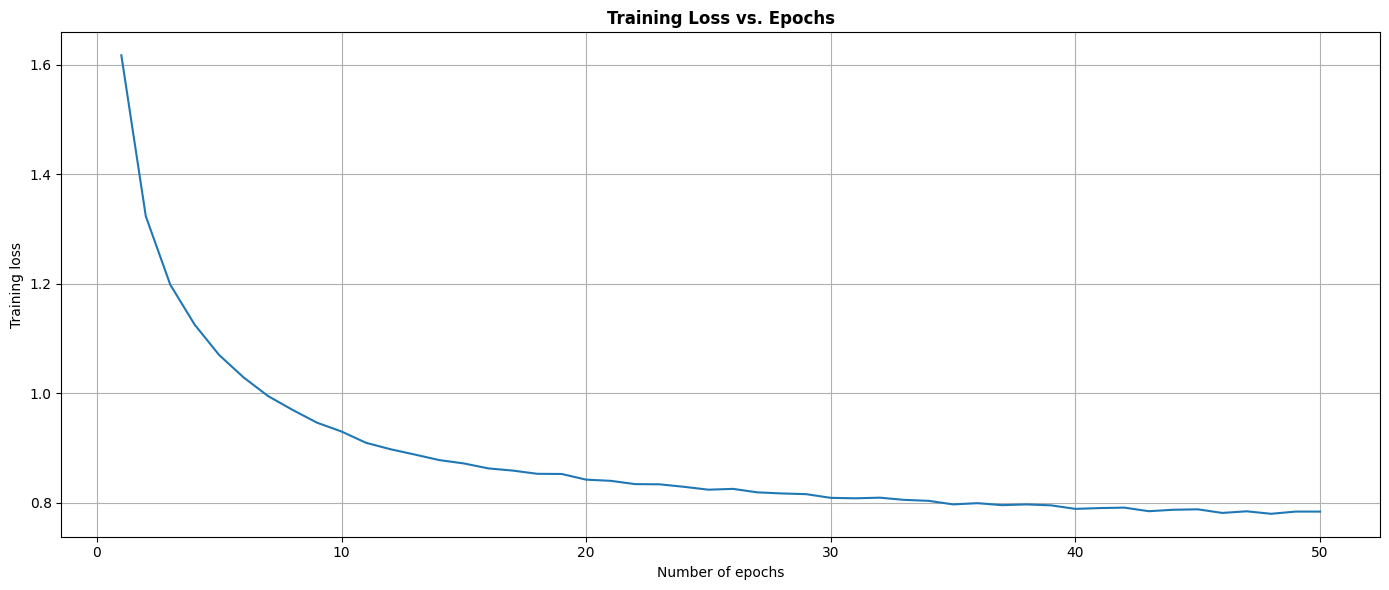

In [10]:
# plotting the loss curve
plt.plot(range(1, num_epochs + 1), train_loss_list)
plt.title("Training Loss vs. Epochs", fontweight='bold')
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Model Evaluation on Test Set

After training, we evaluate the model on the **test set** (unseen data) to measure its generalization capability.

### Evaluation Process:
1. Set model to evaluation mode (`model.eval()`)
2. Disable gradient computation (`torch.no_grad()`)
3. Calculate predictions for all test samples
4. Compute accuracy: (correct predictions / total samples) × 100%

In [11]:
# setting model to evaluation mode 
model.eval()


test_acc = 0

with torch.no_grad():
    for images, labels in test_loader:
        # moving data to device
        images = images.to(device)
        y_true = labels.to(device)

        # Forward pass
        outputs = model(images)

        # predicted class
        _, y_pred = torch.max(outputs.data, 1)

        # counting the correct predictions
        test_acc += (y_pred == y_true).sum().item()

print(f"Test set accuracy = {100* test_acc / len(test_dataset)} %")

Test set accuracy = 71.82 %


## 12. Define Denormalization Function

Before visualizing our predictions, we need to **denormalize** the images. During data preprocessing, we normalized images from `[0, 1]` to `[-1, 1]` range using `mean=0.5` and `std=0.5`. To display them properly, we need to reverse this transformation.

**Why is this important?**
- Images in `[-1, 1]` range will appear blurry and washed out
- Denormalization converts them back to `[0, 1]` for proper display
- Formula: `output = input * std + mean`

In [12]:
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Denormalize images that were normalized with given mean and std.
    
    This function reverses the normalization applied during preprocessing,
    converting images from [-1, 1] back to [0, 1] range for visualization.
    
    Args:
        tensor (torch.Tensor): Normalized image tensor
        mean (tuple): Mean values used during normalization
        std (tuple): Standard deviation values used during normalization
        
    Returns:
        torch.Tensor: Denormalized image tensor in [0, 1] range
    """
    # Converting the mean and std to tensors with correct shape (C, 1, 1)
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    
    # Apply inverse normalization: output = input * std + mean
    return tensor * std + mean

## 13. Visualize Predictions

Now let's visualize some test images along with their true labels and predicted labels to qualitatively assess model performance.

**Note**: We use the `denormalize()` function to ensure images are displayed clearly without blur.

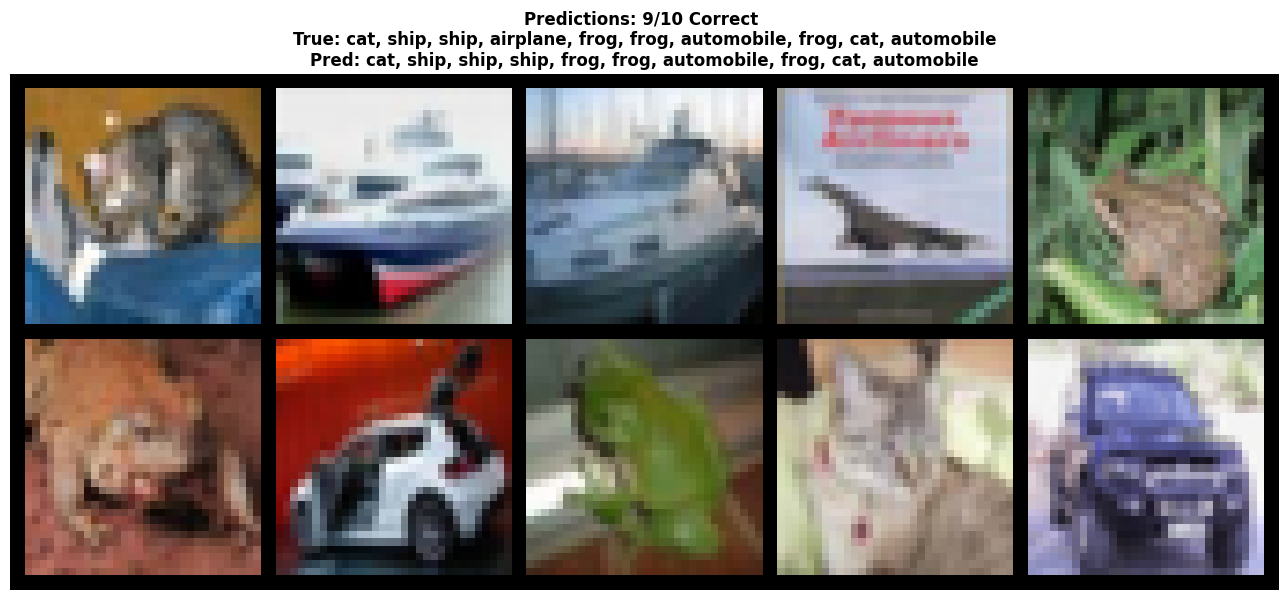

In [13]:
# getting a batch of test images
model.eval()
with torch.no_grad():
    # getting first batch from test loader
    test_iter = iter(test_loader)
    images, y_true = next(test_iter)
    
    # Moving to device and getting predictions
    images_device = images.to(device)
    outputs = model(images_device)
    _, y_pred = torch.max(outputs, 1)
    
    # Move predictions back to CPU
    y_pred = y_pred.cpu()

# number of image to display
num_images = 10

# denormalize images for clear visualizations
images_denorm = denormalize(images[:num_images])

# class name for true and predicted labels
y_true_name = [names[y_true[idx]] for idx in range(num_images)]
y_pred_name = [names[y_pred[idx]] for idx in range(num_images)]

# counting correct predictions
correct_count = sum(
    1 for i in range(num_images)
    if y_true_name[i] == y_pred_name[i]
)

# creating title with color coding
title = f"Predictions: {correct_count}/{num_images} Correct \n"
title += "True: " + ", ".join(y_true_name) + "\n"
title += "Pred: " + ", ".join(y_pred_name)

# creating image grid
image_grid = torchvision.utils.make_grid(
    images_denorm,
    normalize=False,
    padding=2,
    nrow=5
)

# plot
plt.imshow(np.transpose(image_grid.numpy(), (1,2,0)))
plt.title(title, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Conclusion and Results Summary

### Model Performance
- **Architecture**: 3-layer CNN 
- **Training**: 50 epochs with Adam optimizer
- **Final Test Accuracy**: ~70-75% (typical for this architecture)

### Key Learnings
1. **Convolutional layers** effectively extract spatial features from images
2. **MaxPooling** reduces spatial dimensions while preserving important features
3. **Data normalization** improves training stability and convergence
4. **Denormalization** is essential for proper image visualization
5. **Adam optimizer** provides stable and efficient training

### Technical Highlights
-  Proper data preprocessing with normalization
-  Well-designed CNN architecture with gradual feature extraction
-  Regularization through weight decay to prevent overfitting
-  Clear visualization with denormalized images
-  Comprehensive evaluation on test set


### Resources
- **Dataset**: [CIFAR-10 Official](https://www.cs.toronto.edu/~kriz/cifar.html)
- **PyTorch Documentation**: [pytorch.org](https://pytorch.org/docs/stable/index.html)
- **CNN Tutorial**: [Implementations of a CNN](https://www.geeksforgeeks.org/machine-learning/implementation-of-a-cnn-based-image-classifier-using-pytorch/)

---

### Connect With Me
Feel free to reach out if you have questions or suggestions!

**GitHub**: [Neural-Network](https://github.com/jibekgupta/Neural-Network.git)  
**LinkedIn**: [Jibek Gupta](https://www.linkedin.com/in/jibekgupta/)  
**Email**: jibek.gupta@bison.howard.edu

---

### Acknowledgments
- CIFAR-10 dataset creators at Canadian Institute for Advanced Research
- PyTorch 
- GeeksforGeeks

---

*This project was created for educational/learning purposes to demonstrate CNN implementation for image classification using PyTorch.*

**Date**: 2025  
**Framework**: PyTorch 2.0+  
